In [3]:
##### #03/22/2023 Xilin found out it used the last min_action no matter what - revised it
import scipy
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import time
import random
from scipy.stats import beta
import pandas as pd
import copy
%matplotlib inline
%run Helpers.ipynb
#%run pure_strategy_selection.ipynb  #include simple selection algorithm
import scipy.io
import collections
import sys
import itertools


C:\Users\xzhan176\Anaconda3\lib\site-packages\nbformat\__init__.py:92: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


## Mathmatic Functions

In [4]:
# centers the opinion vector around 0\n",
def mean_center(op, n):
    ones = np.ones((n, 1))
    x = op - (np.dot(np.transpose(op),ones)/n) * ones
    return x
    
# compute number of edges, m\n
def num_edges(L, n):
    m = 0
    for i in range(n):
        for j in range(n):
            if i > j and L[i,j] < 0:
                m += 1            
    return m

# maximizing polarization only: \\bar{z}^T \\bar{z}   
def obj_polarization(A, op, n):
    op_mean = mean_center(op, n)
    z_mean = np.dot(A, op_mean) 
    return np.dot(np.transpose(z_mean), z_mean)[0,0] 

def obj_polarization_1(A, L, op, n):
    z = np.dot(A, op) 
    z_mean = mean_center(z, n)
    return np.dot(np.transpose(z_mean), z_mean)[0,0] 

# Calculate innate polarization
def obj_innate_polarization(s, n):  
#     np.set_printoptions(precision=5)
    op_mean = mean_center(s, n)
    return np.dot(np.transpose(op_mean), op_mean)[0,0]

In [5]:
# Parameters for the network
np.set_printoptions(precision=3)
n = 20

## Creating Network
### 1. Make Random Network

In [6]:
def create_erdos_renyi_network(n, p, u, v):
    A = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
#         for j in range(i+1,n):
#             r = np.random.rand()
#             if r < p:
            if j<i:
                A[i,j] = A[j,i] = 1
#             if i==u or i==v:
#                 A[i,j] = A[j,i] = 1
    return A


def make_innat_opinions(n): # Make opinion for agents only - no info source is involved
    
    # Make list of ind innate opinion to define info source opinion
    innat_s = np.random.uniform(low=0, high=1, size=int(n))   #individual's innate opinion 

    s = np.zeros((n, 1))
    
    idx1 = 0
    for i in range(len(s)):
        s[i] = innat_s[idx1]  #set innate opinion for ind.
        idx1 += 1
  
    return s

def make_random_network(n):
    # Create empty graph
    nxG = nx.Graph()
    # Add nodes to graph
    nxG.add_nodes_from(range(n))
    # Add edges based on node index
    for i in range(n):
        for j in range(i):
            p = (n-i)/(n-j) # Probability of edge existing
            if np.random.random() < p:
                nxG.add_edge(i, j)

    # Draw graph
#     nx.draw(nxG, with_labels=True)
#     plt.show()
    G = nx.adjacency_matrix(nxG).todense()
    
    return G



In [7]:
def visualize(s,G):
    # what the twitter graph looks like 
    s_use = s.flatten()   # Convert array to a list for later operation
    s_use = s_use.tolist()
    new_s = [i * 30 for i in s_use]
    df = pd.DataFrame(new_s, columns=['Opinion']) #create a datafram with index at column 1, opinion at column 2

    nxG = nx.from_numpy_matrix(G)   
   
    #plt.figure(figsize=(10, 10))
        ##### Calculate Key Values  ######
    L = scipy.sparse.csgraph.laplacian(G, normed=False)  # Return the Laplacian matrix
    A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)\n  Stanford paper theory
    columnsum_ij = np.sum(A, axis=0)
    m = num_edges(L, n)                    # call the function to calculate the number of edges

#     print(n)
    # what the twitter graph looks like 

    def node_edge(G, n):
        edges =[]
        for v in range(n):
            a = np.array(np.nonzero(G[v])[0])
            edge = len(a)
    #         print(edge)
            edges.append(edge)

        return edges

    node_edges = node_edge(G, n)
    # print(node_edges)

    node_sizes =[]
    for i in node_edges:
        node_size = 1/i*8000
        node_sizes.append(node_size)
        
#     plt.figure(figsize=(20, 20))

    # Fix seed - fix network shape
    my_pos = nx.spring_layout(nxG, seed = 2)
    nx.draw(nxG, pos= my_pos, with_labels= True, node_color=df['Opinion'].astype(int),cmap=plt.cm.Blues, node_size= node_sizes, edge_color='black', width=0.8, font_color='black',font_size=26, font_weight='bold', alpha=0.8)
    #nx.draw(nxG, pos = my_pos, with_labels=False, node_color=color_map, node_size= node_sizes, edge_color='grey', width=0.5, font_color='white',font_size=9, font_weight='bold')
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin = 0, vmax=1))
    cbar = plt.colorbar(sm, shrink = 0.5)
    tick_font_size = 24
    cbar.ax.tick_params(labelsize=tick_font_size)
   # plt.show()
    


# if we want to customize the color bar range to min/max s
# vmin = min(s)
# vmax = max(s)
# sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin = vmin, vmax=vmax))
# sm._A = []
# plt.colorbar(sm,shrink=0.5)
# plt.show()

### Min [245, ] [284, ]       Max [50, ] [481, ] 

### 4. Equilibrium & Polarization  - based on derivation
$$P(z) = z ^T * z $$


In [8]:
# op = s
# y = mean_center(s,n)
# # print(y)
# innat_pol = np.dot(np.transpose(y), y)[0,0] 
# print('Innate_polarization:')
# print(innat_pol)

# # Test equilibrium polarization
# equ_pol = obj_polarization(A, s, n)
# print('Equi_polarization:')
# print(equ_pol)

# di = equ_pol-innat_pol
# print("Difference:")
# print(di)

### Testing players' behavior

In [9]:
def MaxMin_play(s,n, G):    # maxmizer first-time play, greedy algorithm
    #print('Maximizer Play')
    ##### Calculate Key Values  ######
    L = scipy.sparse.csgraph.laplacian(G, normed=False)  # Return the Laplacian matrix
    A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)\n  Stanford paper theory
    columnsum_ij = np.sum(A, axis=0)
    #print(columnsum_ij)
   
    (v1, max_opinion, max_pol, min_action) = choose_max_vertex(s, n,A) # The best choice among all opinions and vertexs, function is in "pure_strategy_selection.ipynb"
    (v2, min_opinion) = min_action
    if v1 == None:   # if maximizer cannot find one
        print('Maximizer fail')
    else:
        print("                                ")
        print("Maximizer finds its target agent:")
#         print('v1', 'changed_opinion', 'innate_obj', 'obj')
#         print(max_champion)

        #Store innate_op of the max_selected vertex
        op = copy.copy(s)
        old_opinion_max = op[v1, 0]
        old_opinion_min = op[v2, 0]
        ##### change the agent's opinion with best action(agent v1, max_op)

        ## check if agent's opinionis is changed or not
        print("Max Action:    "+"Agent" + str(v1) +" 's opinion " + str(old_opinion_max) + " changed to "+ str(max_opinion))
        print("Min Action:    "+"Agent" + str(v2) +" 's opinion " + str(old_opinion_min) + " changed to "+ str(min_opinion))
        print("Network reaches equilibrium Polarization: " + str(max_pol))


    return(v1, v2, max_opinion, min_opinion, max_pol)



# determines if value of opinion at v should be set to 0 or 1 to maximize equilibrium polarization 
def get_max_opinion(s, n, v1,A):
    
    por_arr = np.zeros(2)  # create a two_element array to store polarization value of each option
    max_opi_option = [0, 1.0]   # Maximizer has two options to change agent v1's opinion
    min_actions = []
    # objective if set opinion to 0, 1.0
    j = 0
    for max_opinion in max_opi_option:
        (v2,min_opinion, min_pol) = maxmin_polar(s,v1,max_opinion,A)
        por_arr[j] = min_pol
        j = j + 1   # index increase 1, put the polarization in array
        min_actions.append((v2,min_opinion))

    maxmize_op = np.argmax(por_arr)  # the index of maximum polarization = max_opinion --[0,1]
    max_por = np.max(por_arr)        # find the maximum polarization in the record
    #03/22/2023 Xilin found out it used the last min_action no matter what
    min_action = min_actions[np.argmax(por_arr)]  # the index of maximum polarization --> optimal min action 
    
    
    return (maxmize_op, max_por, min_action)

# determine which agent maximizer should select to maximizer the equilibrium polarization
def choose_max_vertex(s, n,A):
   # max_por = obj_polarization(A, op, n)  # use "innate"(after min action) polarization as a comparable standard to find max_por
    max_por = 0
    C1 = list(range(n))    # for all agent 
    for v1 in C1:         
            #print('Maximizer start from agent'+str(v1))
            (max_opinion, por, min_action) = get_max_opinion(s, n, v1,A)
 
            if por > max_por: # if the polarization of most recent action > maximum polarization of previous actions
                max_por = por
                champion = (v1, max_opinion,max_por, min_action)   # save the this action as champion    

    return (champion)



def maxmin_polar(s, v1, max_opinion,A):
    op = copy.copy(s)
    op[v1] = max_opinion  
    (v2,min_opinion, min_pol) = minimizer_play(op,n,v1,A)
    
    return (v2,min_opinion, min_pol)
    
    
    
##### minimizer first-time play, greedy algorithm
def minimizer_play(op,n,max_touched,A): 
    
    op1 = copy.copy(op)
    min_champion = choose_min_vertex(op1, n, max_touched,A) 
    (v2, min_opinion, min_pol) = min_champion
    
    if v2 == None:
        print('Minimizer fail')

    return (v2,min_opinion, min_pol)


def derivate_s(op,n,v2,A):
    
               #op - opinion array that updated by maximizer
    c = [1/n] * n
#     print(c)
    sum_term = 0
    j = 0

    sum_term = np.dot(np.dot((A-c),(A[v2]-c)),op)  # sum up all terms
    
    term_out = op[v2]*np.dot((A[v2]-c),(A[v2]-c)) # exclude the term that j = v2
    sum_s = sum_term - term_out    # numerator
    
    s_star = -sum_s/np.dot((A[v2]-c),(A[v2]-c))
    s_star = s_star[0] #take value out of array
#     print(str(v2)+'s_star:'+str(s_star))
    #min_opinion =min(max(0,s_star),1)
    bound = (0,1)
    por_arr = []  # create a two_element array to store polarization value of each option
    
    if s_star<0 or s_star>1:
        for min_opinion in bound:
            #change max_opinion array and calculate the polarization
            op1 = copy.copy(op)
            op1[v2] = min_opinion   #after max action, update min action on opinion array
#             print('op1:', op1)
            min_por = obj_polarization(A, op1, n)
            por_arr.append(min_por)
#         print("por_arr:", por_arr)
        minmize_op = np.argmin(por_arr)  # the index of maximum polarization = max_opinion --[0,1]
        min_por = np.min(por_arr)        # find the maximum polarization in the record    
    else:
        minmize_op = s_star
        op1 = copy.copy(op)
        op1[v2] = minmize_op   #after max action, update min action on opinion array
#         print('op1:', op1)
        min_por = obj_polarization(A, op1, n)
        
    return (minmize_op, min_por)
     

    # Minimizer search: Go through each agent 

def choose_min_vertex(op, n, max_touched, A):
    # current opinion array that changed by maximizer, "innate" opinion that min start with

    champion = (None, None, 0, None)  # assume the best action is champion
    min_por = 10000
    all = list(range(n))    # for all agent 
    C1 = [x for x in all if x != max_touched]  # for the vertice that Maximizer has not touched
    
    for v2 in C1:   
        #print('Min start with agent '+ str(v2) )
        (changed_opinion, por) = derivate_s(op,n,v2,A)   # find the best new_op option           

        if por < min_por:  # if the recent polarization is smaller than the minimum polarization in the history
            min_por = por
                                 # update the recent option as champion
            champion = (v2, changed_opinion, min_por)  
    #print("champion:", champion)
    return (champion)  # find the best minimizer's action after going through every new_op option of every agent


### Minimizer Strategy

## Network Analysis

In [16]:
# def net_rank(s,G):
#     #print("___________________Max Analyze__________________________________________")
#     nxG = nx.from_numpy_matrix(G) 
#     # G = nx.karate_club_graph()
#     #print("_______________Degree Centrality_____________________________")  
#     deg_centrality = nx.degree_centrality(nxG)
#     sortedDict = sorted(deg_centrality.items(), key=lambda x:x[1])
#     converted_dict = dict(sortedDict)
#     # print(converted_dict)
#     #print("                           ")
#     #print("_______________Closeness Rank_____________________________")
#     close_centrality = nx.closeness_centrality(nxG)
#     sortedDict1 = sorted(close_centrality.items(), key=lambda x:x[1])
#     converted_dict1 = dict(sortedDict1)
#     # print(converted_dict1)
#     #print("                           ")
#     #print("_______________Page Rank_____________________________")
#     pr = nx.eigenvector_centrality(nxG)
#     sortedDict2 = sorted(pr.items(), key=lambda x:x[1])
#     converted_dict2 = dict(sortedDict2)
#     # print(converted_dict2)

#     #print("                           ")

#     def gap(op, n):
#         ones = np.ones((n, 1))
#         x = op - (np.dot(np.transpose(op),ones)/n) * ones
#         return abs(x)

#     gap = gap(s,n)
#     my_gap = {index: value for index, value in enumerate(gap)}
#     sorting_gap = sorted(my_gap.items(), key=lambda x:x[1], reverse=True)
#     sorted_gap = dict(sorting_gap)
#     #print(sorted_gap)
#     return (converted_dict,converted_dict1,converted_dict2,sorted_gap)

# def pred(N,converted_dict,converted_dict1,converted_dict2,sorted_gap):
#     # Using islice() + items()
#     # Get first N items in dictionary
#     a = list(itertools.islice(converted_dict.keys(), N))
#     b = list(itertools.islice(converted_dict1.keys(), N))
#     c = list(itertools.islice(converted_dict2.keys(), N))


#     max_pred = sorted(np.unique(a+b+c))
# #     print("Max limited by K is : " + str(max_pred))
#     min_pred = list(itertools.islice(sorted_gap.keys(), N))
#     # printing result
# #     print("Min limited by K is : " + str(min_pred))
    
#     return (max_pred, min_pred)



    


In [60]:
def net_rank(s,G):
    #print("___________________Max Analyze__________________________________________")
    nxG = nx.from_numpy_matrix(G) 
    # G = nx.karate_club_graph()
    #print("_______________Degree Centrality_____________________________")  
    deg_centrality = nx.degree_centrality(nxG)
    sortedDict = sorted(deg_centrality.items(), key=lambda x:x[1])
    converted_dict = dict(sortedDict)
    # print(converted_dict)
    #print("                           ")
    #print("_______________Closeness Rank_____________________________")
    close_centrality = nx.closeness_centrality(nxG)
    sortedDict1 = sorted(close_centrality.items(), key=lambda x:x[1])
    converted_dict1 = dict(sortedDict1)
    # print(converted_dict1)
    #print("                           ")
    #print("_______________Page Rank_____________________________")
    pr = nx.eigenvector_centrality(nxG)
    sortedDict2 = sorted(pr.items(), key=lambda x:x[1])
    converted_dict2 = dict(sortedDict2)
    # print(converted_dict2)

    #print("                           ")

    def gap(op, n):
        ones = np.ones((n, 1))
        x = op - (np.dot(np.transpose(op),ones)/n) * ones
        return abs(x)

    gap = gap(s,n)
    my_gap = {index: value for index, value in enumerate(gap)}
    sorting_gap = sorted(my_gap.items(), key=lambda x:x[1], reverse=True)
    sorted_gap = dict(sorting_gap)
#     print("opinion - mean")
#     print(sorted_gap)
    return (converted_dict,converted_dict1,converted_dict2,sorted_gap)

def pred_error(s, G, max_pol, v1, min_pred):
    op = copy.copy(s)
    op[v1] = max_opinion  # change max's action 
    op1 = copy.copy(op)
    op1[min_pred] = np.mean(s) #change predicted min's node to mean opinion
    L = scipy.sparse.csgraph.laplacian(G, normed=False)  # Return the Laplacian matrix
    A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)\n  Stanford paper theory
    pred_por = obj_polarization(A, op1, n)
    dif = max_pol-pred_por
    print("difference in prediction:"+str(abs(max_pol-pred_por)))
    
    return dif



def pred(N,converted_dict,converted_dict1,converted_dict2,sorted_gap):
    # Using islice() + items()
    # Get first N items in dictionary
    a = list(itertools.islice(converted_dict.keys(), N))
    b = list(itertools.islice(converted_dict1.keys(), N))
    c = list(itertools.islice(converted_dict2.keys(), N))
    
    #___________________Max predct___________________
    max_pred = c
    #max_pred = sorted(np.unique(a+b+c))
    
    
    #____________________Min predict ________________
    #min_pred = list(itertools.islice(sorted_gap.keys(), N))
#     def predic1(n,converted_dict,converted_dict1,converted_dict2,sorted_gap)
#     #_________predict 1
#         # print("__opinion__")
#         rank1_list = list(range(n))
#         #print(rank1_list)
#         op_order = sorted_gap.keys()
#         op_ranks= dict(zip(op_order, rank1_list))
#         #print("__centrality__")
#         ecen_order = converted_dict2.keys()
#         ecen_ranks=dict(zip(ecen_order, rank1_list))
#         #print("*********new ranks*************")      
#         new_rank = {i: 0.5*op_ranks.get(i, 0) + 0.5*ecen_ranks.get(i, 0) for i in set(op_ranks).union(ecen_ranks)}
#         #print(new_rank)
#         sorting_rank = sorted(new_rank.items(), key=lambda x:x[1])
#         sorted_rank = dict(sorting_rank)
#     #     print(sorted_rank)
#         min_pred1= list(itertools.islice(sorted_rank.keys(), N))
#         ecen_dict = copy.copy(converted_dict2)
#         first_key = next(iter(ecen_dict)) 
#         ecen_dict.pop(first_key)
#         min_pred2= list(itertools.islice(ecen_dict.keys(), N))
#         min_pred = min_pred1 + min_pred2
#     return (min_pred)

    #_________predict 2
#     min_pred = [np.argmax(s)]
    


    #printing result
    print("Min limited by K is : " + str(min_pred))
    max_pred = c
    print("Max limited by K is : " + str(max_pred))
    
    return (max_pred, min_pred)



In [90]:
# #generate data
# (converted_dict,converted_dict1,converted_dict2,sorted_gap)= net_rank(s,G)
# (v1, v2, max_opinion, min_opinion, max_pol)  = MaxMin_play(s,n,G)

                                
Maximizer finds its target agent:
Max Action:    Agent19 's opinion 0.9352090992053902 changed to 0
Min Action:    Agent10 's opinion 0.9567112040383532 changed to 0.11551538007312342
Network reaches equilibrium Polarization: 0.02596581174179393


__opinion__
2
{2: 0, 14: 1, 16: 2, 10: 3, 19: 4, 15: 5, 0: 6, 6: 7, 9: 8, 3: 9, 13: 10, 8: 11, 11: 12, 18: 13, 1: 14, 7: 15, 17: 16, 4: 17, 5: 18, 12: 19}
__centrality__
[19, 18, 16, 17, 15]
{19: 0, 18: 1, 16: 2, 17: 3, 15: 4, 14: 5, 3: 6, 13: 7, 4: 8, 11: 9, 10: 10, 9: 11, 5: 12, 1: 13, 2: 14, 12: 15, 7: 16, 0: 17, 8: 18, 6: 19}
__shortest_path__
{19: 0, 18: 1, 11: 1, 6: 1, 0: 2, 1: 2, 2: 2, 3: 2, 5: 2, 7: 2, 8: 2, 9: 2, 10: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 4: 3}
fist 5 extre op:[2, 14, 16, 10, 19]
overlap
{16, 19}
min_pred
{16, 19}
Mins' action features
10 opinion: [0.957]
10 neighbors: (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64), array([ 1,  3,  6,  7,  8,  9, 12, 13, 15, 17], dtype=int64))
Opinion rank of this agent is : 20
_______________Degree Centrality___________________
rank of this agent is : 10
0.5263157894736842
                           
_______________Closeness Rank________________________
rank of this agent is : 10
0.6785714285714286
                

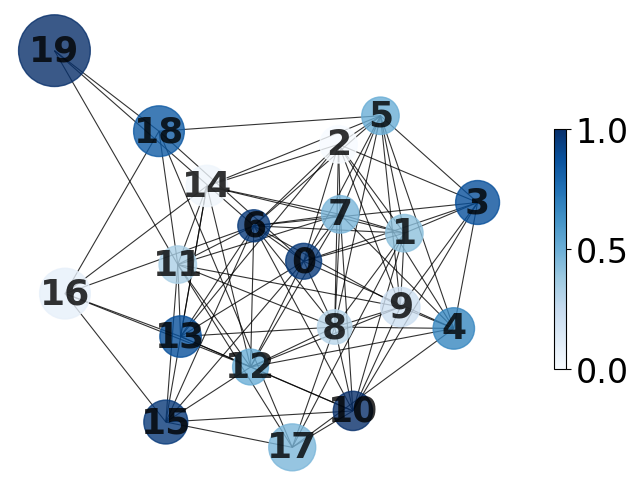

In [98]:
# visualize(s,G)
# a = list(itertools.islice(converted_dict.keys(), N))
# b = list(itertools.islice(converted_dict1.keys(), N))
# c = list(itertools.islice(converted_dict2.keys(), N))

# # ___________________Min predict algorithm

# rank1_list = list(range(n))
# #print(rank1_list)
# op_order = sorted_gap.keys()
# op_ranks= dict(zip(op_order, rank1_list))
# print("__opinion__")
# print(list(sorted_gap.keys())[0])
# print(op_ranks)


# ecen_order = converted_dict2.keys()
# ecen_ranks=dict(zip(ecen_order, rank1_list))
# print("__centrality__")
# print(list(ecen_order)[:5])
# print(ecen_ranks)

# nxG = nx.from_numpy_matrix(G)
# all_shortest_paths = dict(nx.shortest_path_length(nxG, target=v1))
# print("__shortest_path__")
# print(all_shortest_paths)

# Fst_extre_op = list(sorted_gap.keys())[0]
# F5_eig_cen = list(ecen_order)[:5]
# if Fst_extre_op in F5_eig_cen:
#     min_pred = Fst_extre_op
#     print('min_pred')
#     print(min_pred)
# else:
#     F5_extre_op = list(sorted_gap.keys())[:5]
#     print("fist 5 extre op:"+str(F5_extre_op))
#     overlap = set(F5_extre_op).intersection(F5_eig_cen)
#     print("overlap")
#     print(overlap)
#     if len(overlap) > 0:
#         min_pred = overlap
#         print('min_pred')
#         print(min_pred)

# print("Mins' action features")
# network_anl(s,n,G,v2)

In [118]:
def gap(op, n):
    ones = np.ones((n, 1))
    x = op - (np.dot(np.transpose(op),ones)/n) * ones
    return x

gap = gap(s,n)
    
extre_rank = []
for agent in range(n):
    if gap[agent] < 0:
        my_gap = {index: value for index, value in enumerate(gap) if value<0}
        sorting_gap = sorted(my_gap.items(), key=lambda x:x[1])
        sorted_gap = dict(sorting_gap)
        temp4 = list(sorted_gap.items()) 
        res4 = [idx for idx, key in enumerate(temp4) if key[0]==agent][0]+1
        print("Agent"+str(agent)+"'s opinion extremity is ranked as: " + str(res4))
        extre_rank.append((agent,res4))
    else:
        my_gap = {index: value for index, value in enumerate(gap) if value>=0}
        sorting_gap = sorted(my_gap.items(), key=lambda x:x[1], reverse=True)
        sorted_gap = dict(sorting_gap)
        temp4 = list(sorted_gap.items()) 
        res4 = [idx for idx, key in enumerate(temp4) if key[0]==agent][0]+1
        print("Agent"+str(agent)+"'s opinion extremity is ranked as: " + str(res4))
        extre_rank.append((agent,res4))
extre_ranks = dict(extre_rank)
print(extre_ranks)
sorted_opext_dict = dict(sorted(extre_ranks.items(), key=lambda x:x[1]))
print(sorted_opext_dict)
node_wtih_extre = min(sorted_opext_dict, key=sorted_opext_dict.get)
print(node_wtih_extre)

Agent0's opinion extremity is ranked as: 4
Agent1's opinion extremity is ranked as: 7
Agent2's opinion extremity is ranked as: 1
Agent3's opinion extremity is ranked as: 6
Agent4's opinion extremity is ranked as: 9
Agent5's opinion extremity is ranked as: 10
Agent6's opinion extremity is ranked as: 5
Agent7's opinion extremity is ranked as: 8
Agent8's opinion extremity is ranked as: 5
Agent9's opinion extremity is ranked as: 4
Agent10's opinion extremity is ranked as: 1
Agent11's opinion extremity is ranked as: 6
Agent12's opinion extremity is ranked as: 11
Agent13's opinion extremity is ranked as: 7
Agent14's opinion extremity is ranked as: 2
Agent15's opinion extremity is ranked as: 3
Agent16's opinion extremity is ranked as: 3
Agent17's opinion extremity is ranked as: 9
Agent18's opinion extremity is ranked as: 8
Agent19's opinion extremity is ranked as: 2
{0: 4, 1: 7, 2: 1, 3: 6, 4: 9, 5: 10, 6: 5, 7: 8, 8: 5, 9: 4, 10: 1, 11: 6, 12: 11, 13: 7, 14: 2, 15: 3, 16: 3, 17: 9, 18: 8, 19

In [ ]:
def 

In [113]:
print(np.argmax(s))
print(s)

10
[[0.92 ]
 [0.491]
 [0.153]
 [0.845]
 [0.681]
 [0.537]
 [0.917]
 [0.525]
 [0.399]
 [0.329]
 [0.957]
 [0.401]
 [0.552]
 [0.839]
 [0.173]
 [0.922]
 [0.217]
 [0.532]
 [0.804]
 [0.935]]


In [97]:
# (v1,v2,max_pol) = MaxMin_play(s,n)
def run(n):
    s = make_innat_opinions(n)
    G = make_random_network(n)
    (a,b,c,d)= net_rank(s,G)
#   visualize(s,G)
    (v1, v2, max_opinion, min_opinion, max_pol) = MaxMin_play(s,n,G)
    
    return (v1,v2, max_opinion, min_opinion,max_pol, s, G, a,b,c,d)


In [51]:
# DIF = pred_error(s, G, max_pol, v1, min_pred)
# print(DIF)
#     op = copy.copy(s)
#     op[v1] = max_opinion  # change max's action 
#     op1 = copy.copy(op)
#     op1[min_pred] = np.mean(s) #change predicted min's node to mean opinion
#     L = scipy.sparse.csgraph.laplacian(G, normed=False)  # Return the Laplacian matrix
#     A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)\n  Stanford paper theory
#     pred_por = obj_polarization(A, op1, n)
#     dif = max_pol-pred_por
#     print("difference in prediction:"+str(abs(max_pol-pred_por)))

difference in prediction:0.005517246302388361
-0.005517246302388361


## the 3rd metrics


In [54]:
# print("Predict Min's action")
# N = 2
# (a,b,c,d) = net_rank(s,G)
# (max_pred, min_pred) = pred(N,a,b,c,d)
# print("min_prediction")
# print(min_pred)

# print(np.nonzero(G[max_pred]))
# print("try to predict")

# ####################################### the third metric is here############################
# nxG = nx.from_numpy_matrix(G)
# all_shortest_paths = dict(nx.shortest_path_length(nxG, target=v1))
# p = nx.shortest_path_length(G, target=v1) 
# distance = p[i] for i in list(range(n))
# print(all_shortest_paths)

{19: 0, 16: 1, 4: 1, 0: 2, 1: 2, 2: 2, 3: 2, 5: 2, 6: 2, 9: 2, 10: 2, 11: 2, 13: 2, 14: 2, 15: 2, 17: 2, 18: 2, 7: 3, 8: 3, 12: 3}


In [84]:
# # s = make_innat_opinions(n)
# def gap(op, n):
#     ones = np.ones((n, 1))
#     x = op - (np.dot(np.transpose(op),ones)/n) * ones
#     return abs(x)

# gap = gap(s,n)
# my_gap = {index: value for index, value in enumerate(gap)}
# sorting_gap = sorted(my_gap.items(), key=lambda x:x[1], reverse=True)
# sorted_gap = dict(sorting_gap)

# # G = make_random_network(n)

# nxG = nx.from_numpy_matrix(G) 
# pr = nx.eigenvector_centrality(nxG)
# sortedDict2 = sorted(pr.items(), key=lambda x:x[1])
# converted_dict2 = dict(sortedDict2)

# print("*********opinion*************")
# rank1_list = list(range(n))
# #print(rank1_list)
# op_order = sorted_gap.keys()
# print(sorted_gap)
# op_ranks= dict(zip(op_order, rank1_list))
# print(op_ranks)

# print("*********centrality*************")
# ecen_order = converted_dict2.keys()
# print(ecen_order)
# ecen_ranks=dict(zip(ecen_order, rank1_list))
# print(converted_dict2)
# print(ecen_ranks)
      
# print("*********new ranks*************")      
# new_rank = {i: op_ranks.get(i, 0) + ecen_ranks.get(i, 0) for i in set(op_ranks).union(ecen_ranks)}
# print(new_rank)
# sorting_rank = sorted(new_rank.items(), key=lambda x:x[1])
# sorted_rank = dict(sorting_rank)
# print(sorted_rank)
# #min_pred= list(itertools.islice(sorted_rank.keys(), N))

# first_key = next(iter(converted_dict2)) 
# converted_dict2.pop(first_key)
# min_pred= list(itertools.islice(converted_dict2.keys(), N))
# print(min_pred)

*********opinion*************
{16: array([0.507]), 7: array([0.49]), 4: array([0.483]), 5: array([0.455]), 1: array([0.409]), 10: array([0.398]), 19: array([0.397]), 14: array([0.346]), 0: array([0.327]), 11: array([0.276]), 6: array([0.208]), 13: array([0.201]), 2: array([0.199]), 12: array([0.151]), 18: array([0.124]), 17: array([0.111]), 9: array([0.072]), 3: array([0.033]), 8: array([0.026]), 15: array([0.024])}
{16: 0, 7: 1, 4: 2, 5: 3, 1: 4, 10: 5, 19: 6, 14: 7, 0: 8, 11: 9, 6: 10, 13: 11, 2: 12, 12: 13, 18: 14, 17: 15, 9: 16, 3: 17, 8: 18, 15: 19}
*********centrality*************
dict_keys([19, 17, 18, 0, 15, 5, 16, 14, 12, 7, 8, 11, 2, 13, 6, 1, 4, 3, 9, 10])
{19: 0.02557147294105924, 17: 0.09403449436520665, 18: 0.103997605265035, 0: 0.1511463607650038, 15: 0.1727093901912854, 5: 0.2025011856304909, 16: 0.2073704147497721, 14: 0.2074287315993877, 12: 0.21866940543524208, 7: 0.22397627315247579, 8: 0.23584339561772563, 11: 0.23808998873723136, 2: 0.2398749340596189, 13: 0.25258

In [85]:
def network_anl(s,n,G,agent):

    print(str(agent)+' opinion: ' + str(s[agent]))
    print(str(agent)+' neighbors: '+ str(np.nonzero(G[agent])))

    s_aa = s[:, 0]
    my_dict = {index: value for index, value in enumerate(s_aa)}
    sorting_s = sorted(my_dict.items(), key=lambda x:x[1])
    sorted_S = dict(sorting_s)
    res = rank(sorted_S,agent)
    # printing result 
    print("Opinion rank of this agent is : " + str(res))



    #print("___________________Max Analyze__________________________________________")
    nxG = nx.from_numpy_matrix(G) 
    # G = nx.karate_club_graph()
    print("_______________Degree Centrality___________________")  
    deg_centrality = nx.degree_centrality(nxG)
    sortedDict = sorted(deg_centrality.items(), key=lambda x:x[1])
    converted_dict = dict(sortedDict)
    res1 = rank(converted_dict,agent)
    print("rank of this agent is : " + str(res1))
    print(converted_dict[agent])

    # print(converted_dict)
    print("                           ")
    print("_______________Closeness Rank________________________")
    close_centrality = nx.closeness_centrality(nxG)
    sortedDict1 = sorted(close_centrality.items(), key=lambda x:x[1])
    converted_dict1 = dict(sortedDict1)
    res2 = rank(converted_dict1,agent)
    print("rank of this agent is : " + str(res2))
    print(converted_dict1[agent])
    # print(converted_dict1)
    print("                           ")
    print("_______________Page Rank_____________________________")
    pr = nx.eigenvector_centrality(nxG)
    sortedDict3 = sorted(pr.items(), key=lambda x:x[1])
    converted_dict3 = dict(sortedDict3)
    res3 = rank(converted_dict3,agent)
    print("rank of this agent is : " + str(res3))
    print(converted_dict3[agent])
    # print(converted_dict3)

    print("                           ")

    def gap(op, n):
        ones = np.ones((n, 1))
        x = op - (np.dot(np.transpose(op),ones)/n) * ones
        return x

    gap = gap(s,n)
    if gap[agent] < 0:
        my_gap = {index: value for index, value in enumerate(gap) if value<0}
        sorting_gap = sorted(my_gap.items(), key=lambda x:x[1])
        sorted_gap = dict(sorting_gap)
        temp4 = list(sorted_gap.items()) 
        res4 = [idx for idx, key in enumerate(temp4) if key[0]==agent][0]+1
        print("Agent's opinion extremity is ranked as: " + str(res4))
    else:
        my_gap = {index: value for index, value in enumerate(gap) if value>=0}
        sorting_gap = sorted(my_gap.items(), key=lambda x:x[1], reverse=True)
        sorted_gap = dict(sorting_gap)
        temp4 = list(sorted_gap.items()) 
        res4 = [idx for idx, key in enumerate(temp4) if key[0]==agent][0]+1
        print("Agent's opinion extremity is ranked as: " + str(res4))
    print("Agent's min_pref is ranked as: " + str(res4+res1))

In [ ]:
def rank(scores,agent):
    ranks =1
    for i in range(len(scores)):
        if scores[agent] > scores[i]:
            ranks += 1
        elif scores[agent]  == scores[i]:
            ranks = ranks
    return ranks